## Session 5:

### Performance Tunning

- Caching - Concepts, Storage Type, Guidelines
- Minimizing Shuffling for Increased Performance
- Using Broadcast Variables and Accumulators
- General Performance Guidelines

In [1]:
#Build basic spark session
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Demo") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
spark

In [4]:
twinkleDF = spark.read.text("/home/ec2-user/spark-labs/data/twinkle/500M.data")

In [15]:
twinkleDF.count()

2934557

In [16]:
twinkleDF.count()

2934557

In [7]:
twinkleDF.cache()

DataFrame[value: string]

In [8]:
twinkleDF.count()

2934557

In [9]:
#Create RDD
twinkleRDD = sc.textFile("/home/ec2-user/spark-labs/data/twinkle/500M.data")

In [10]:
twinkleRDD.count()

2934557

In [11]:
twinkleRDD.cache()

/home/ec2-user/spark-labs/data/twinkle/500M.data MapPartitionsRDD[24] at textFile at NativeMethodAccessorImpl.java:0

In [14]:
twinkleRDD.count()

2934557

In [18]:
twinkleDF.unpersist()

DataFrame[value: string]

In [19]:
#Use StorageLevel.MEMORY_ONLY for Dataframe to make it serialized to reduce
# the memory size
from pyspark import StorageLevel
twinkleDF.persist(StorageLevel.MEMORY_ONLY)

DataFrame[value: string]

In [20]:
twinkleDF.count()

2934557

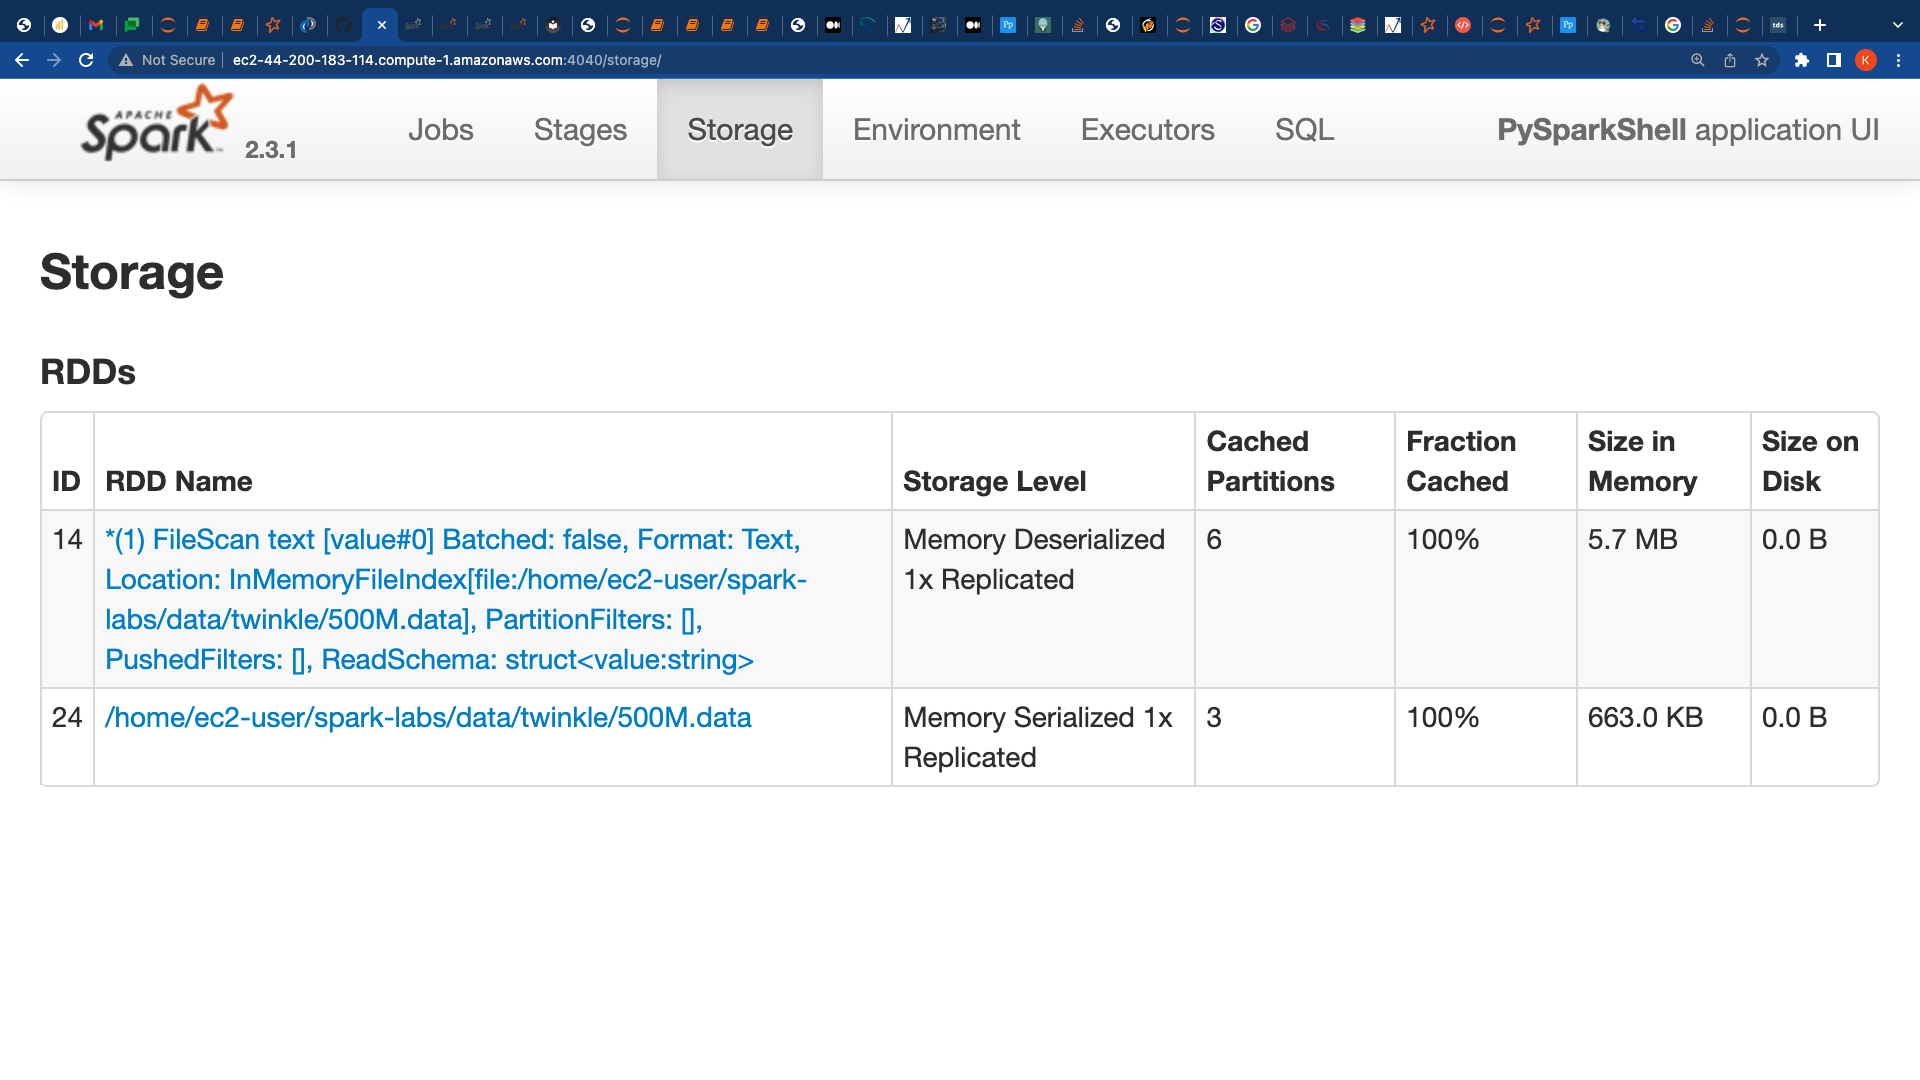

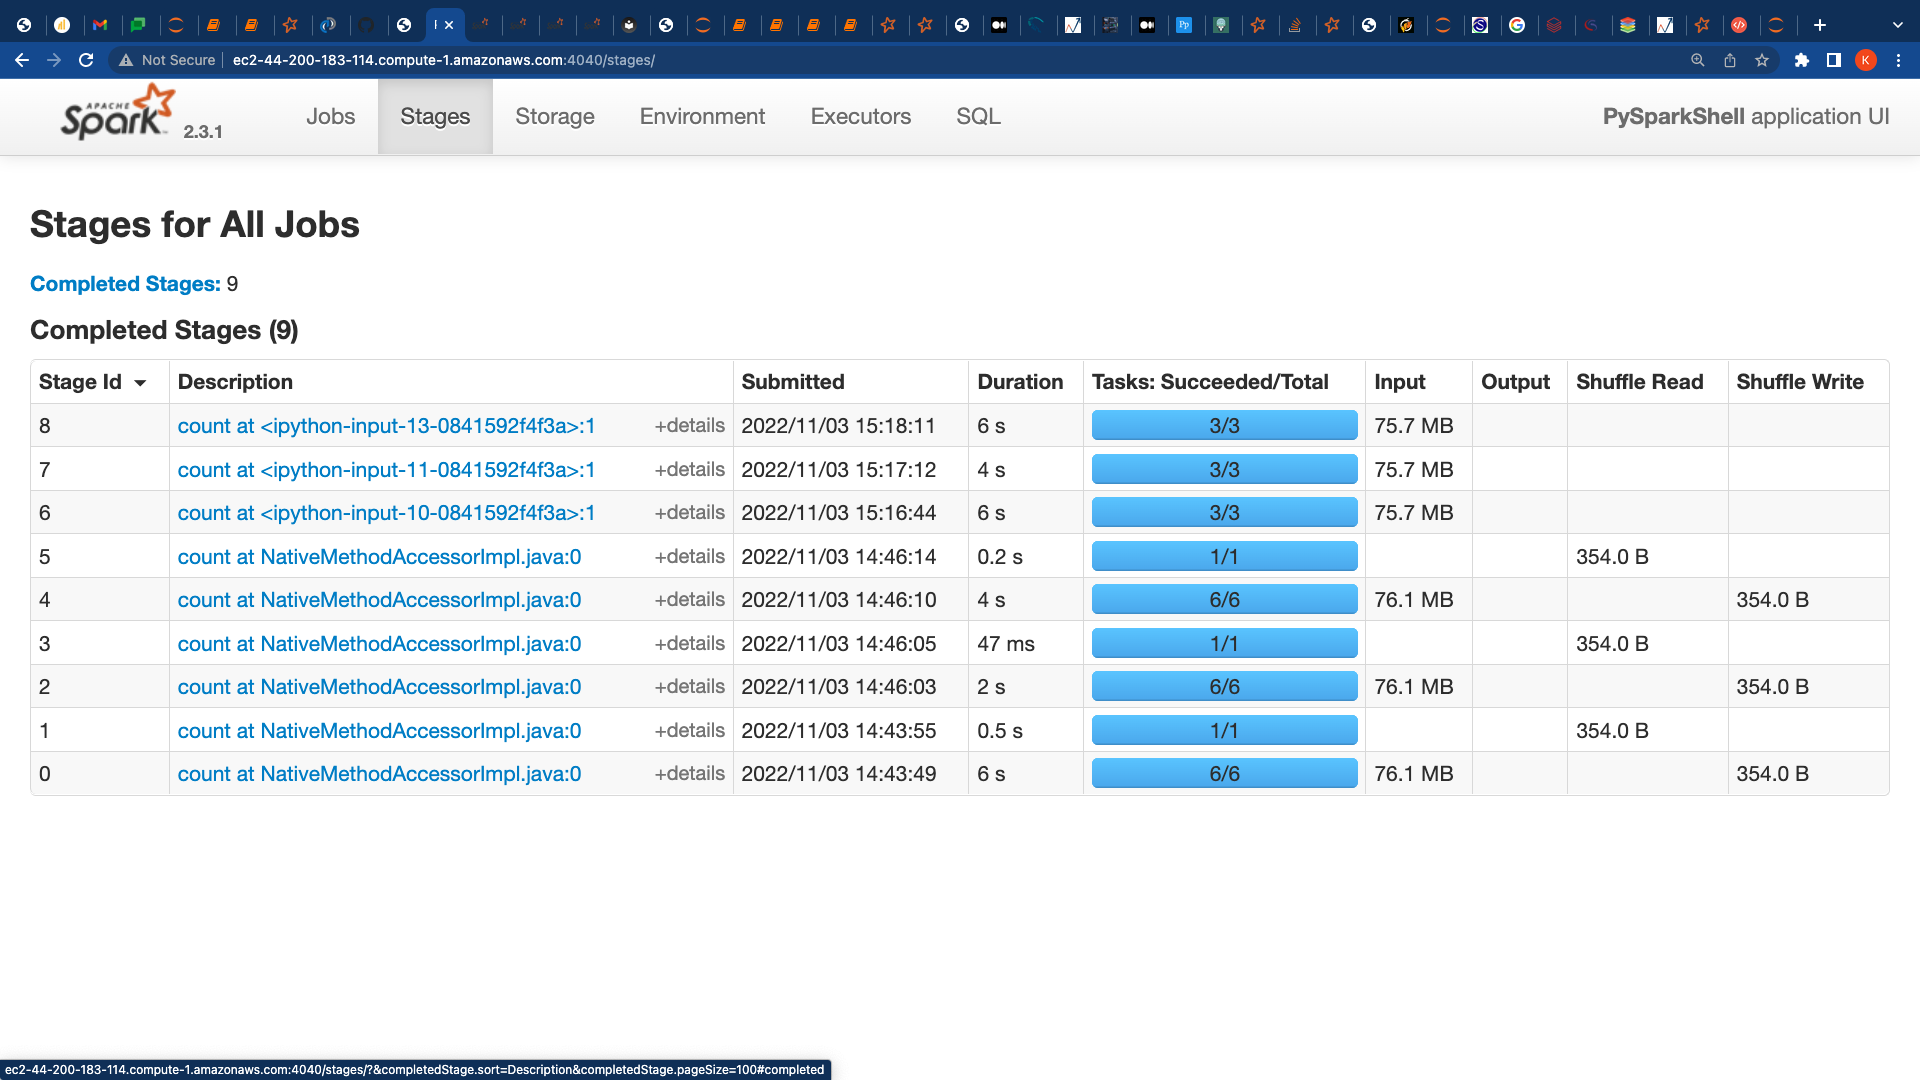

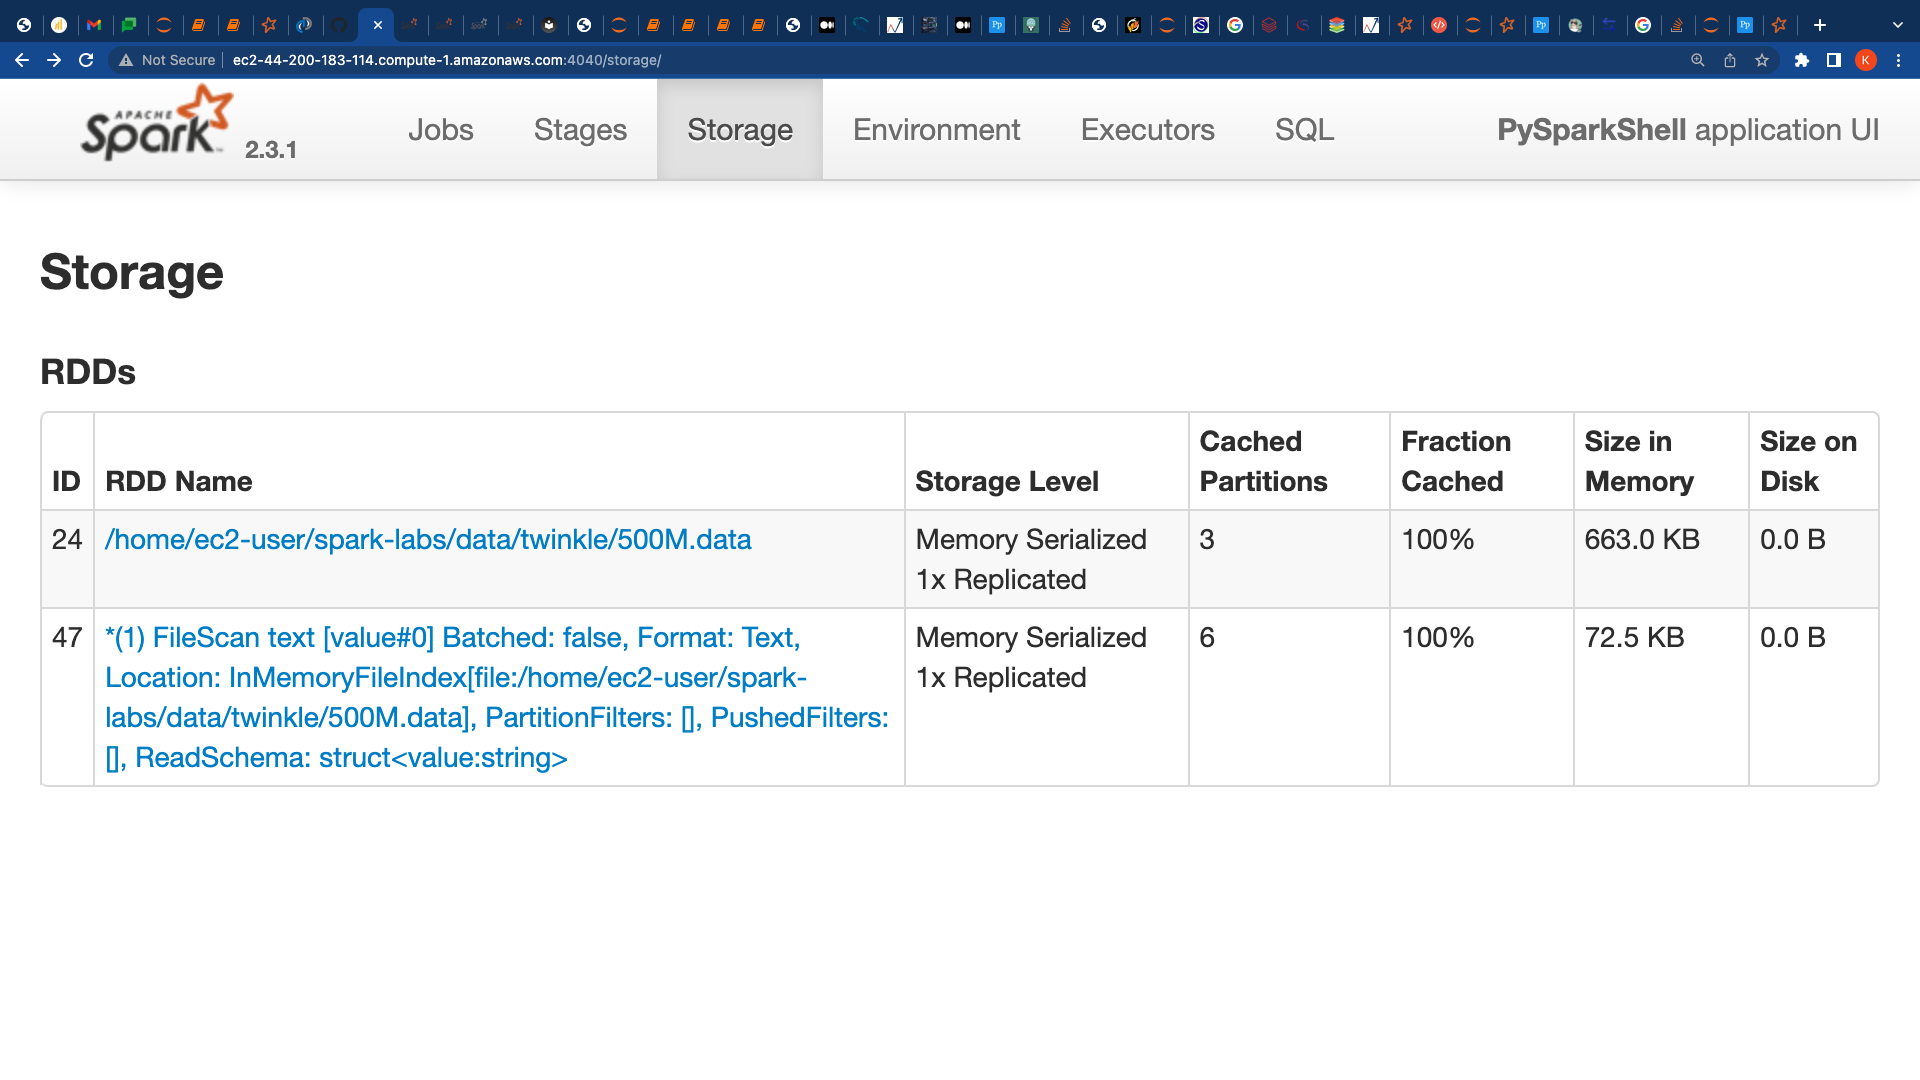

#### Results of Cache Operation for RDD and Dataframe:
- If your observe the duration to execute the action before and after caching dataframe and RDD,Dataframe takes less time to perform action of counting same dataset.
- After caching RDD,storage level is memory serialized whereas for dataframe it's deserialized.Also,RDD takes less memory as compared to dataframe.To reduce the memory size of dataframe,to make it serealized storage level,we can use df.persist(pyspark.StorageLevel.MEMORY_ONLY)which increases the performance of spark.We know that dataframe uses Spark SQL and inbuilt optimization techniques i.e. catalyst and tungusten engine. 

#### Joins,Shuffles,Broadcasta,Accumulators:
- Join operations are a common type of transformation in big data analytics in which two data sets, in the form of tables or DataFrames, are merged over a common matching key.

###### Lab5.2:
- To find out the 20 contributors who have the most entries in the github data.

In [3]:
# Load githubDf
githubDF=spark.read.json("/home/ec2-user/spark-labs/data/github.json")

In [4]:
githubDF.show(5)

+--------------------+--------------------+----------+--------------------+--------------------+------+--------------------+-----------------+
|               actor|          created_at|        id|                 org|             payload|public|                repo|             type|
+--------------------+--------------------+----------+--------------------+--------------------+------+--------------------+-----------------+
|[https://avatars....|2015-03-01T00:00:00Z|2614896652|[https://avatars....|[,,,, ,,,,, maste...|  true|[23934080, Early-...|      CreateEvent|
|[https://avatars....|2015-03-01T00:00:00Z|2614896653|                null|[, 6dda286a3a1c25...|  true|[31481156, bezerr...|        PushEvent|
|[https://avatars....|2015-03-01T00:00:00Z|2614896654|                null|[, 6089ce1d78dc0a...|  true|[31475673, demian...|        PushEvent|
|[https://avatars....|2015-03-01T00:00:00Z|2614896656|                null|[created,, [, ```...|  true|[31481077, chrsmi...|IssueCommentEvent|

In [4]:
#Scan to find out the 20 contributors who have the most entries in the github data. 
scanQuery=githubDF.groupBy('actor.login').count().orderBy('count',ascending=False)

In [5]:
scanQuery.show()

+------------------+-----+
|             login|count|
+------------------+-----+
|GoogleCodeExporter| 2073|
|         stackmutt|  284|
|      greatfirebot|  192|
|diversify-exp-user|  146|
|            kwurst|   92|
|   direwolf-github|   88|
|     KenanSulayman|   72|
|        jack-oquin|   52|
|        manuelrp07|   45|
|    mirror-updates|   42|
|     tryton-mirror|   37|
|        EstifanosG|   32|
|           houndci|   30|
|      jeff1evesque|   29|
|      LukasReschke|   28|
|           Somasis|   27|
|       nwt-patrick|   27|
|        mikegazdag|   26|
|       tterrag1098|   23|
|   EmanueleMinotto|   22|
+------------------+-----+
only showing top 20 rows



In [17]:
scanQuery.explain()

== Physical Plan ==
*(3) Sort [count#245L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(count#245L DESC NULLS LAST, 200)
   +- *(2) HashAggregate(keys=[actor#62.login#263], functions=[count(1)])
      +- Exchange hashpartitioning(actor#62.login#263, 200)
         +- *(1) HashAggregate(keys=[actor#62.login AS actor#62.login#263], functions=[partial_count(1)])
            +- *(1) FileScan json [actor#62] Batched: false, Format: JSON, Location: InMemoryFileIndex[file:/home/ec2-user/spark-labs/data/github.json], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<actor:struct<avatar_url:string,gravatar_id:string,id:bigint,login:string,url:string>>


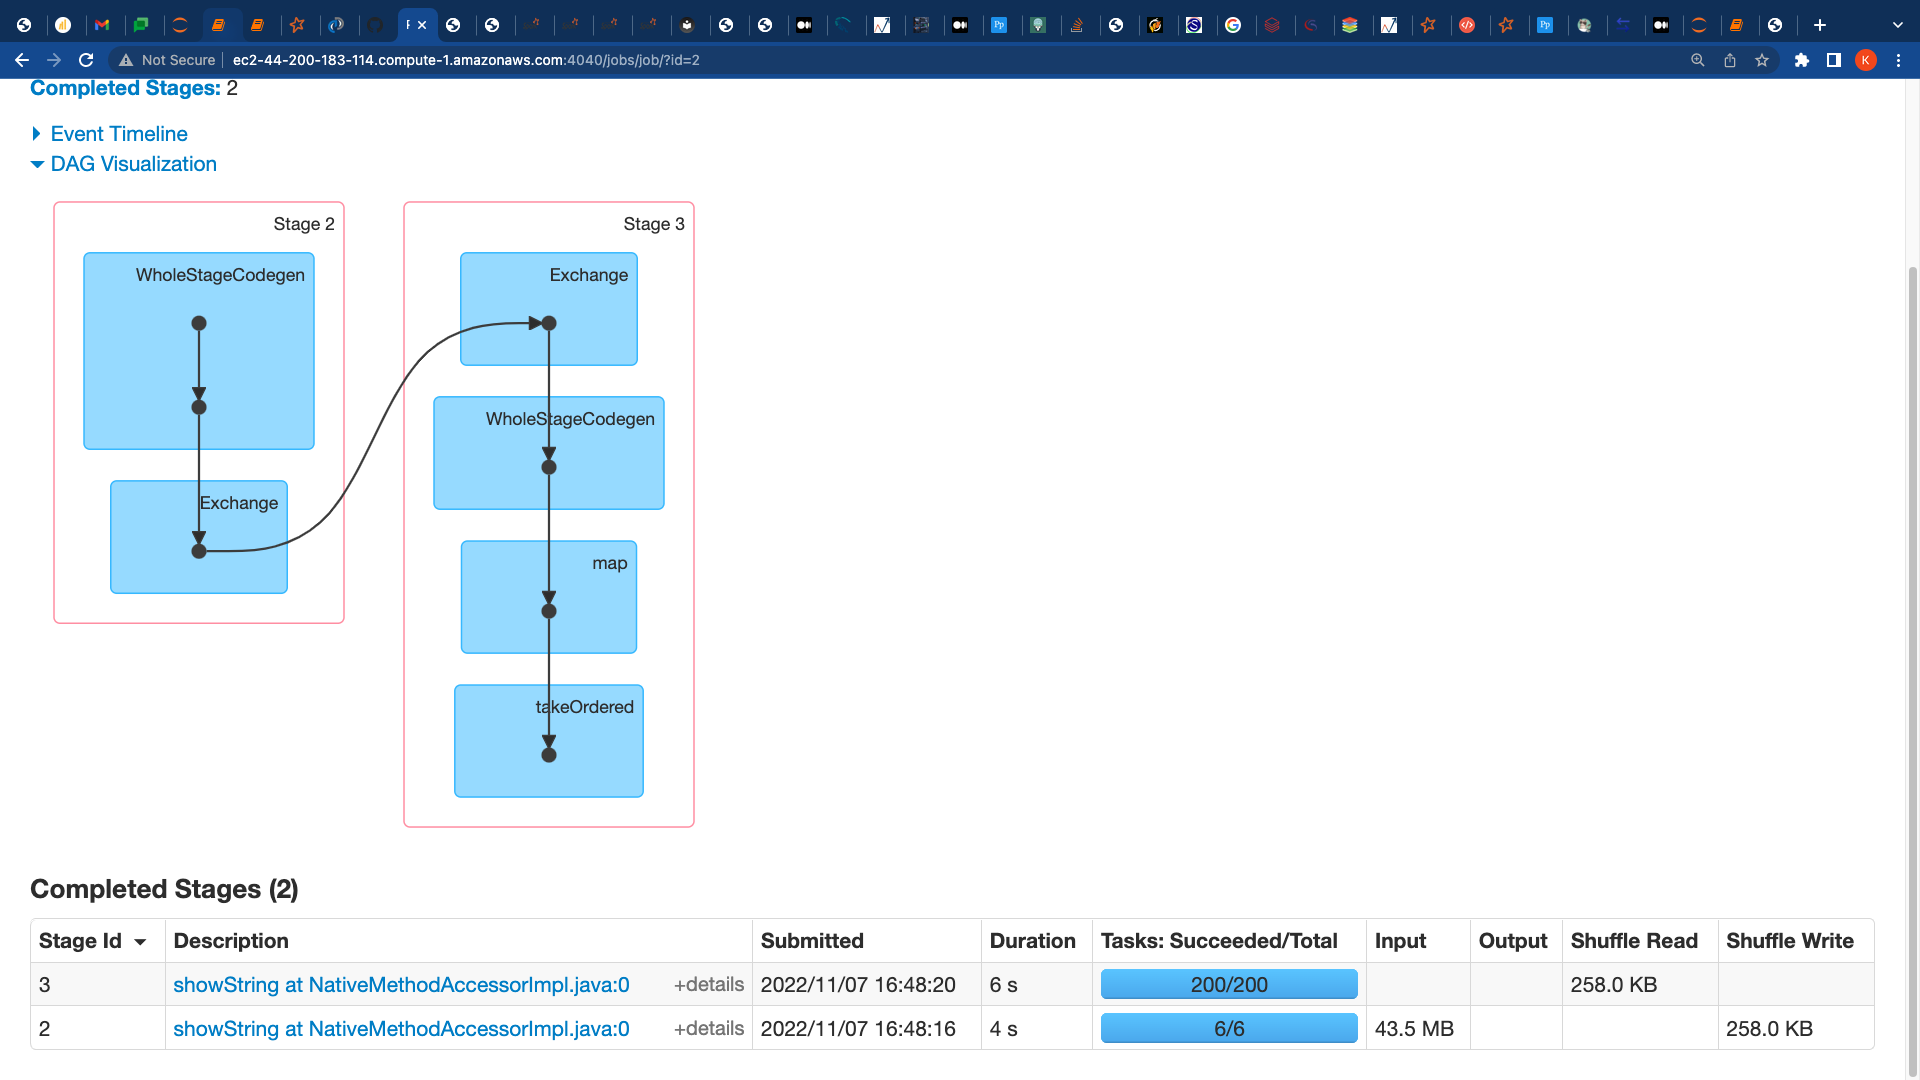

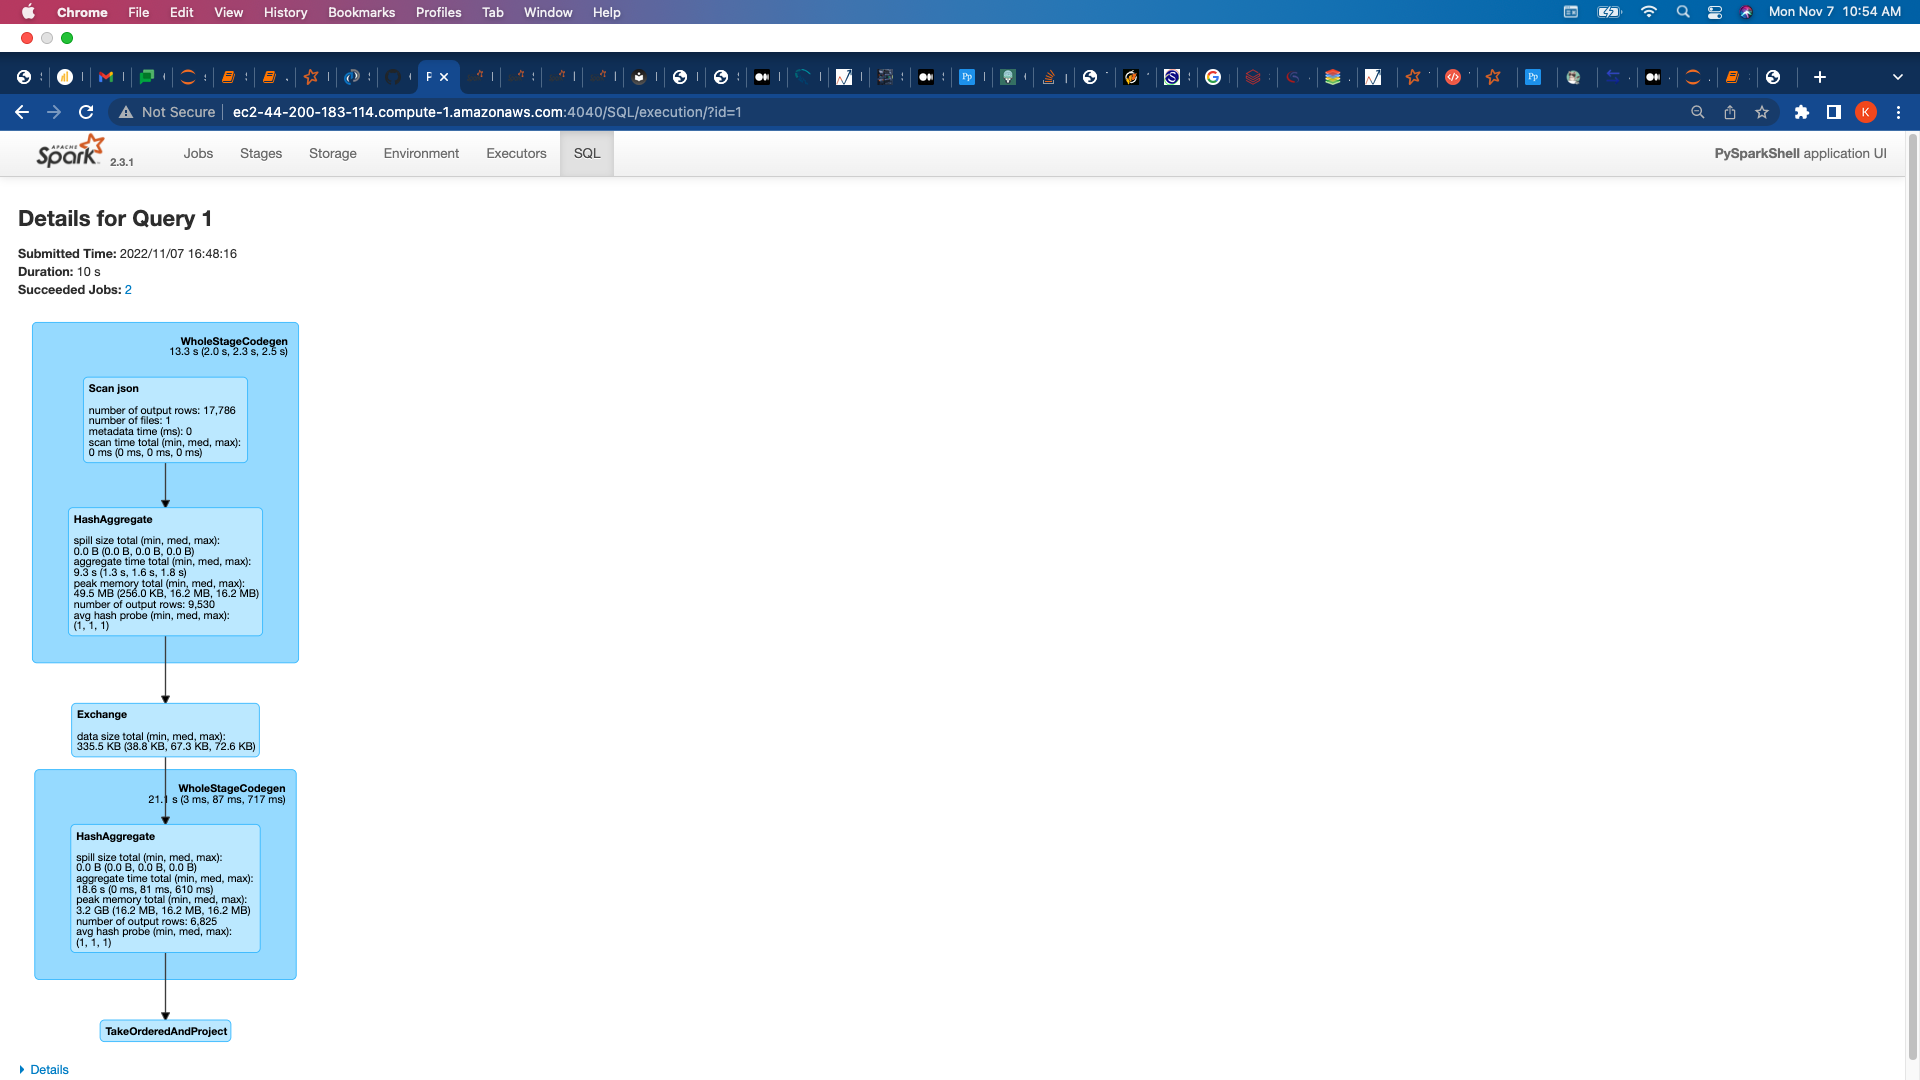

#### Top 20 Contributors - Join Query:
Write a join query that gives the actor login and count from the entries in github.json for the login values in github-top20.json.

Review the data in github-top20.json.
Accomplish our query needs by:
Loading github-top20.json into a dataframe (githubTop20DF) Joining githubDF and githubTop20DF
Grouping by actor.login
Counting the results, and ordering by descending count.

In [6]:
# Load github-top20.json
githubTop20DF=spark.read.json("/home/ec2-user/spark-labs/data/github-top20.json")

In [8]:
githubTop20DF.show()

+------------------+
|             login|
+------------------+
|GoogleCodeExporter|
|         stackmutt|
|      greatfirebot|
|diversify-exp-user|
|            kwurst|
|   direwolf-github|
|     KenanSulayman|
|        jack-oquin|
|        manuelrp07|
|    mirror-updates|
|     tryton-mirror|
|        EstifanosG|
|           houndci|
|      jeff1evesque|
|      LukasReschke|
|       nwt-patrick|
|           Somasis|
|        mikegazdag|
|       tterrag1098|
|   EmanueleMinotto|
+------------------+



In [7]:
# Join githubTop20DF and githubDF
#Joining githubDF and githubTop20DF Grouping by actor.login 
#Counting the results, and ordering by descending count
topContributorsJoinedDF=githubDF.join(githubTop20DF,githubDF.actor.login==githubTop20DF.login).groupBy(githubDF.actor.login).count().orderBy("count",ascending=False)

In [8]:
topContributorsJoinedDF.show()

+------------------+-----+
|    actor['login']|count|
+------------------+-----+
|GoogleCodeExporter| 2073|
|         stackmutt|  284|
|      greatfirebot|  192|
|diversify-exp-user|  146|
|            kwurst|   92|
|   direwolf-github|   88|
|     KenanSulayman|   72|
|        jack-oquin|   52|
|        manuelrp07|   45|
|    mirror-updates|   42|
|     tryton-mirror|   37|
|        EstifanosG|   32|
|           houndci|   30|
|      jeff1evesque|   29|
|      LukasReschke|   28|
|           Somasis|   27|
|       nwt-patrick|   27|
|        mikegazdag|   26|
|       tterrag1098|   23|
|   EmanueleMinotto|   22|
+------------------+-----+



In [13]:
topContributorsJoinedDF.explain(True)

== Parsed Logical Plan ==
'Sort ['count DESC NULLS LAST], true
+- AnalysisBarrier
      +- Aggregate [actor#62.login], [actor#62.login AS actor['login']#191, count(1) AS count#190L]
         +- Join Inner, (actor#62.login = login#145)
            :- Relation[actor#62,created_at#63,id#64,org#65,payload#66,public#67,repo#68,type#69] json
            +- Relation[login#145] json

== Analyzed Logical Plan ==
actor['login']: string, count: bigint
Sort [count#190L DESC NULLS LAST], true
+- Aggregate [actor#62.login], [actor#62.login AS actor['login']#191, count(1) AS count#190L]
   +- Join Inner, (actor#62.login = login#145)
      :- Relation[actor#62,created_at#63,id#64,org#65,payload#66,public#67,repo#68,type#69] json
      +- Relation[login#145] json

== Optimized Logical Plan ==
Sort [count#190L DESC NULLS LAST], true
+- Aggregate [actor#62.login], [actor#62.login AS actor['login']#191, count(1) AS count#190L]
   +- Project [actor#62]
      +- Join Inner, (actor#62.login = login#145)
    

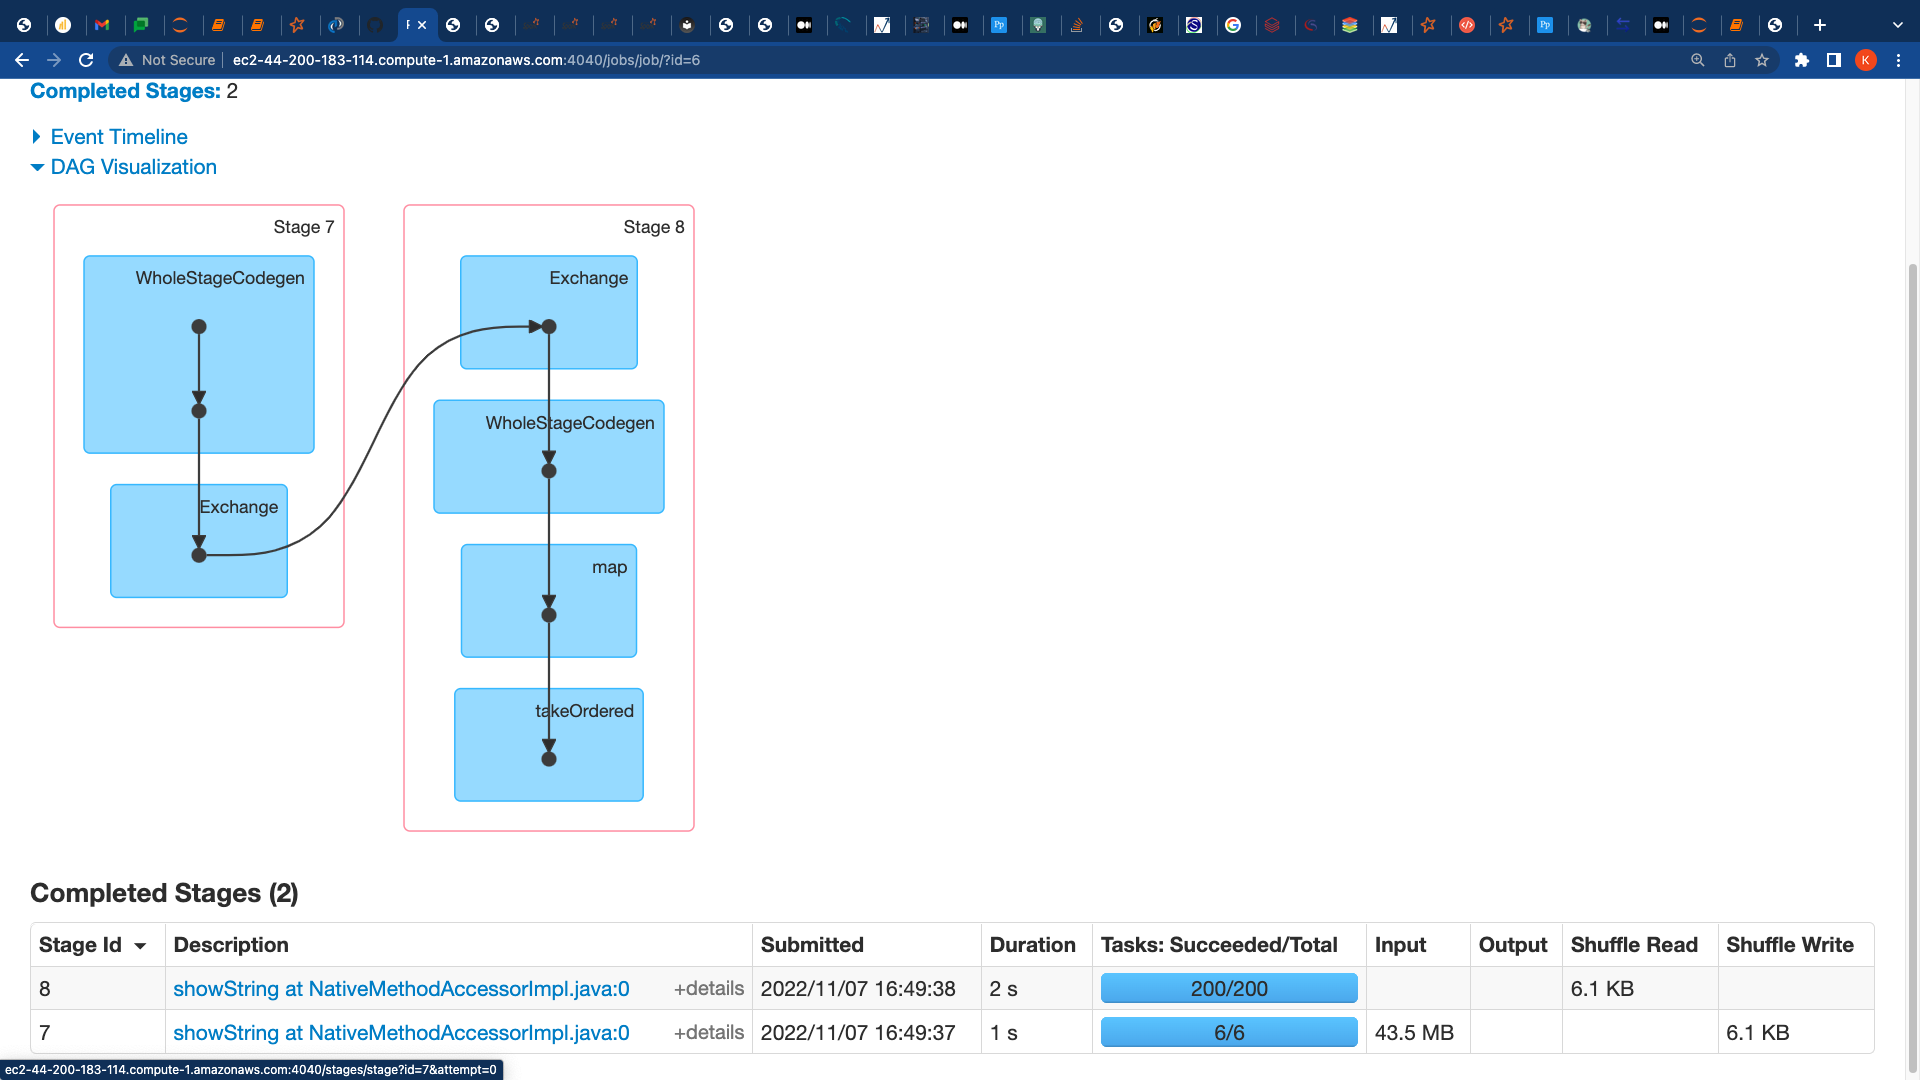

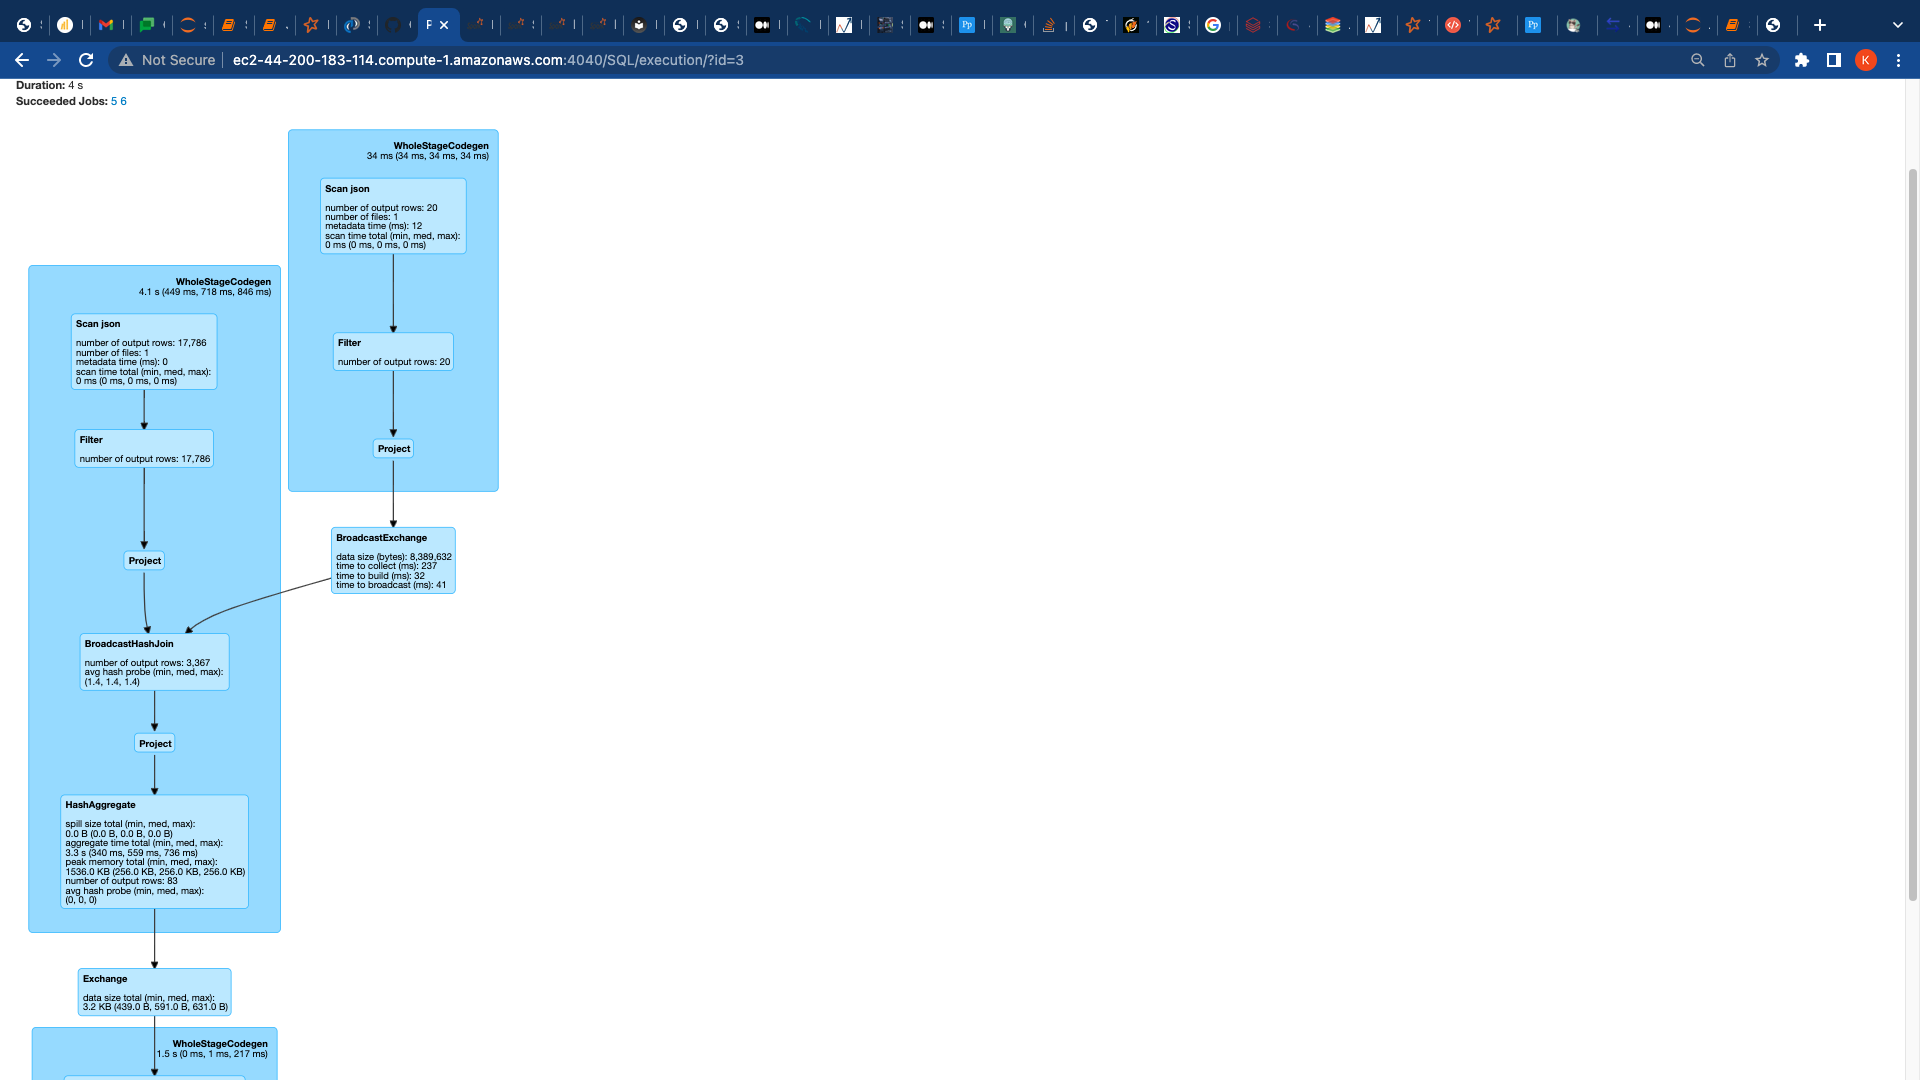

##### Join Performance without Broadcast:
- Let's disable the Catalyst broadcast optimization and look at what happens.
- Disable automatic broadcasting, by setting the appropriate configuration property as follow:
  - spark.conf.set("spark.sql.autoBroadcastJoinThreshold",-1)

In [9]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold",-1)

In [10]:
#Join with Disabling Catalyst broadcast optimization 
topContributorsJoinedDF=githubDF.join(githubTop20DF,githubDF.actor.login==githubTop20DF.login).groupBy(githubDF.actor.login).count().orderBy("count",ascending=False)

In [11]:
topContributorsJoinedDF.show()

+------------------+-----+
|    actor['login']|count|
+------------------+-----+
|GoogleCodeExporter| 2073|
|         stackmutt|  284|
|      greatfirebot|  192|
|diversify-exp-user|  146|
|            kwurst|   92|
|   direwolf-github|   88|
|     KenanSulayman|   72|
|        jack-oquin|   52|
|        manuelrp07|   45|
|    mirror-updates|   42|
|     tryton-mirror|   37|
|        EstifanosG|   32|
|           houndci|   30|
|      jeff1evesque|   29|
|      LukasReschke|   28|
|       nwt-patrick|   27|
|           Somasis|   27|
|        mikegazdag|   26|
|       tterrag1098|   23|
|   EmanueleMinotto|   22|
+------------------+-----+



In [12]:
topContributorsJoinedDF.explain()

== Physical Plan ==
*(7) Sort [count#149L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(count#149L DESC NULLS LAST, 200)
   +- *(6) HashAggregate(keys=[actor#6.login#167], functions=[count(1)])
      +- Exchange hashpartitioning(actor#6.login#167, 200)
         +- *(5) HashAggregate(keys=[actor#6.login AS actor#6.login#167], functions=[partial_count(1)])
            +- *(5) Project [actor#6]
               +- *(5) SortMergeJoin [actor#6.login], [login#55], Inner
                  :- *(2) Sort [actor#6.login ASC NULLS FIRST], false, 0
                  :  +- Exchange hashpartitioning(actor#6.login, 200)
                  :     +- *(1) Project [actor#6]
                  :        +- *(1) Filter isnotnull(actor#6)
                  :           +- *(1) FileScan json [actor#6] Batched: false, Format: JSON, Location: InMemoryFileIndex[file:/home/ec2-user/spark-labs/data/github.json], PartitionFilters: [], PushedFilters: [IsNotNull(actor)], ReadSchema: struct<actor:struct<avatar_url

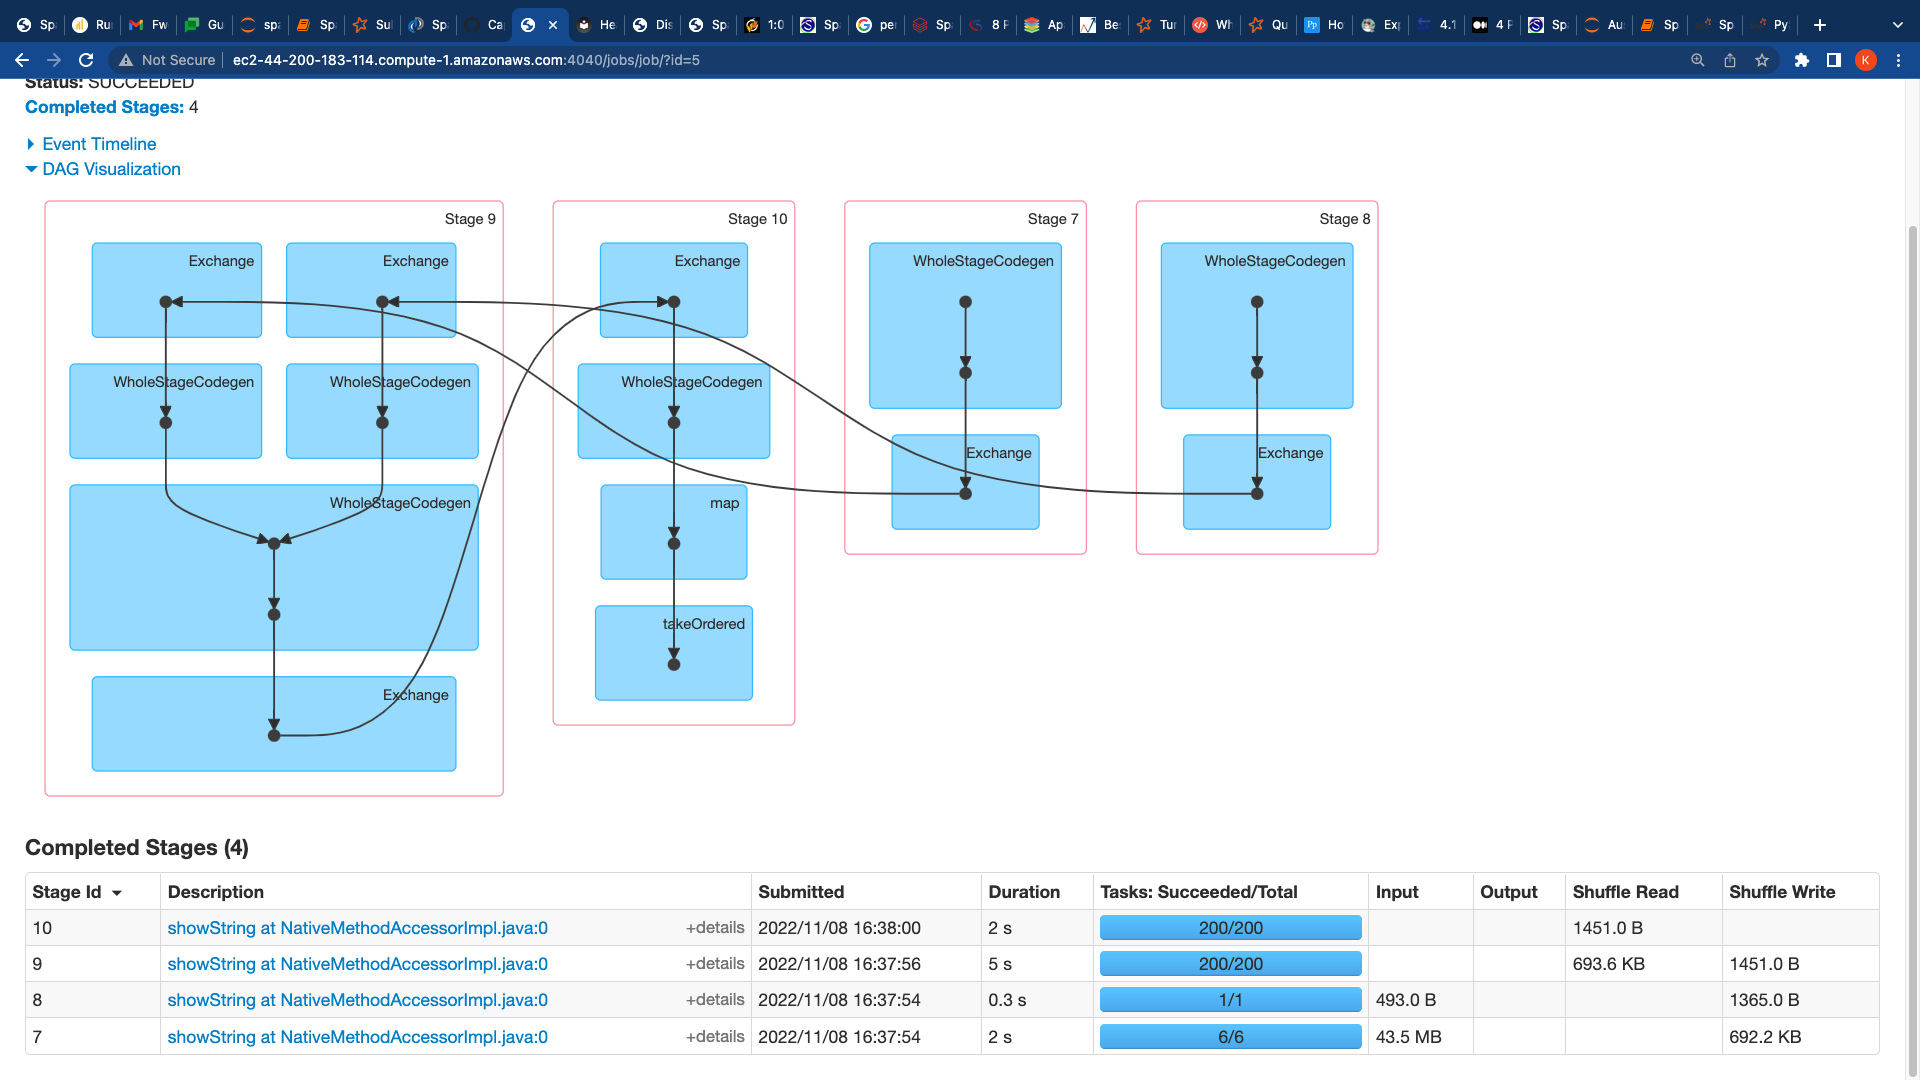

##### Result After disabling automatic broadcast: 
- Broadcast join has go away instead it's using SortMergeJoin and Exchange hashpartitioning(shuffling)
- Number of stages doubled as a result executation time is more.It's shuffling more data i.e.692.2KB whereas for with broadcast join it was 6.1KB.
- We can say that automatic broadcasting improves the performance of spark
- Let renable automatic broadcast using **spark.conf.set("spark.sql.autoBroadcastJoinThreshold",1024x1024x10)**

In [13]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold",1024*1024*10)

In [15]:
topContributorsJoinedDF=githubDF.join(githubTop20DF,githubDF.actor.login==githubTop20DF.login).groupBy(githubDF.actor.login).count().orderBy("count",ascending=False)

In [16]:
topContributorsJoinedDF.explain()

== Physical Plan ==
*(4) Sort [count#205L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(count#205L DESC NULLS LAST, 200)
   +- *(3) HashAggregate(keys=[actor#6.login#210], functions=[count(1)])
      +- Exchange hashpartitioning(actor#6.login#210, 200)
         +- *(2) HashAggregate(keys=[actor#6.login AS actor#6.login#210], functions=[partial_count(1)])
            +- *(2) Project [actor#6]
               +- *(2) BroadcastHashJoin [actor#6.login], [login#55], Inner, BuildRight
                  :- *(2) Project [actor#6]
                  :  +- *(2) Filter isnotnull(actor#6)
                  :     +- *(2) FileScan json [actor#6] Batched: false, Format: JSON, Location: InMemoryFileIndex[file:/home/ec2-user/spark-labs/data/github.json], PartitionFilters: [], PushedFilters: [IsNotNull(actor)], ReadSchema: struct<actor:struct<avatar_url:string,gravatar_id:string,id:bigint,login:string,url:string>>
                  +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, s

In [1]:
broadcastVar = sc.broadcast([1, 2, 3])

In [2]:
broadcastVar.value

[1, 2, 3]

In [3]:
broadcastVar.value[2]

3

In [4]:
accum = sc.accumulator(0)

In [5]:
sc.parallelize([1, 2, 3, 4]).foreach(lambda x: accum.add(x))

In [6]:
accum.value

10